In [8]:
from deepsudoku import REPO_PATH, DIFFICULTIES
import os
os.chdir(REPO_PATH)

import tensorflow as tf
import numpy as np
from deepsudoku.reinforcement_learning.ppo import *

import gymnasium as gym
from deepsudoku.verify_sudoku import *

In [9]:
size = 3
sq_size = np.square(size)
sudoku_input_shape = (sq_size, sq_size, sq_size+1)
missing_digits = 5

In [10]:
# Create Discrete models

# Implementation Detail 2: Orthogonal Initialization of hidden weights and constant initialization of biases and output weights
# Biases seem to be 0 by default in Keras
hidden_ortho_init = lambda: tf.keras.initializers.Orthogonal(gain=np.sqrt(2))
pol_out_ortho_init = lambda: tf.keras.initializers.Orthogonal(gain=0.01)
val_out_ortho_init = lambda: tf.keras.initializers.Orthogonal(gain=1)

def create_policy_model():
    inputs = tf.keras.Input(shape=sudoku_input_shape)
    x = tf.keras.layers.Conv2D(16, 3, padding="same", data_format="channels_last", activation="relu", kernel_initializer=hidden_ortho_init())(inputs)
    x = tf.keras.layers.Conv2D(16, 3, padding="same", data_format="channels_last", activation="relu", kernel_initializer=hidden_ortho_init())(x)
    x = tf.keras.layers.Conv2D(9, 9, padding="same", data_format="channels_last", activation="linear", kernel_initializer=pol_out_ortho_init())(x)
    outputs = tf.keras.layers.Flatten(data_format="channels_last")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="pi")
    return model

def create_value_function_model():
    inputs = tf.keras.Input(shape=sudoku_input_shape)
    pre = tf.keras.layers.Flatten(data_format="channels_last")(inputs)
    x = tf.keras.layers.Dense(128, activation="tanh", kernel_initializer=hidden_ortho_init())(pre)
    x = tf.keras.layers.Dense(256, activation="tanh", kernel_initializer=hidden_ortho_init())(x)
    outputs = tf.keras.layers.Dense(1, activation="linear", kernel_initializer=val_out_ortho_init())(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="V")
    return model

In [11]:
def preprocessing(observation):
    return tf.one_hot(observation, 10, axis=-1)

In [12]:
# create sudoku action mask
def action_mask(observation, logits, epsilon=1):
    #r = np.random.rand(*observation.shape)
    for y, x in np.ndindex(observation.shape):
        #if observation[y,x] != 0 and r[y,x] < epsilon:
        if observation[y,x] != 0:
            act_space_ind = y*(sq_size**2)+x*(sq_size)
            #converting from sudoku-board index to action-space index, see env.py
            logits[act_space_ind:act_space_ind+sq_size] = -1e8
    return logits

In [13]:
envs = PPO_Discrete_Environment_Wrapper('Sudoku-x0', 50, action_mask = action_mask, size=size, missing_digits=missing_digits, preprocessing_function=preprocessing)

In [14]:
pi, V = PPO(envs, create_policy_model(), create_value_function_model(), multi_discrete=False, STEPS_PER_TRAJECTORY=50, TRAIN_EPOCHS = 2500, LEARNING_RATE_START=0.001)

epoch:  0  ; KL:  0  ; LR:  0.001  ; MR:  0  ; EPS:  0
Collection
Tapework
epoch:  1  ; KL:  1.0882816  ; LR:  0.0009996  ; MR:  -0.7896  ; EPS:  0.9861758129746041
Collection
Tapework
epoch:  2  ; KL:  0.086828716  ; LR:  0.0009992  ; MR:  -0.7736  ; EPS:  0.9861359478186987
Collection
Tapework
epoch:  3  ; KL:  0.14031787  ; LR:  0.0009988  ; MR:  -0.7712  ; EPS:  0.9860959693234562
Collection
Tapework
epoch:  4  ; KL:  0.08057285  ; LR:  0.0009984  ; MR:  -0.7488  ; EPS:  0.986055877176006
Collection
Tapework
epoch:  5  ; KL:  0.11204274  ; LR:  0.000998  ; MR:  -0.7848  ; EPS:  0.986015671062667
Collection
Tapework
epoch:  6  ; KL:  0.100738056  ; LR:  0.0009976  ; MR:  -0.7768  ; EPS:  0.9859753506689479
Collection
Tapework
epoch:  7  ; KL:  0.05674539  ; LR:  0.0009972  ; MR:  -0.7408  ; EPS:  0.9859349156795432
Collection
Tapework
epoch:  8  ; KL:  0.07008148  ; LR:  0.0009968  ; MR:  -0.7424  ; EPS:  0.9858943657783331
Collection
Tapework
epoch:  9  ; KL:  0.04164511  ; LR:  0.

KeyboardInterrupt: 

In [7]:
pi.save('notebooks/ppo_tests/some_model_')


NameError: name 'pi' is not defined

In [9]:
pi = tf.keras.models.load_model('notebooks/ppo_tests/some_model_')

In [17]:
envs.test_policy(pi, 1000)

2.1306127670461814

In [10]:

test_env = gym.make('Sudoku-x0', render_mode='human', size=size, missing_digits=missing_digits)
#test_env = gym.make('CartPole-v1', render_mode='human')


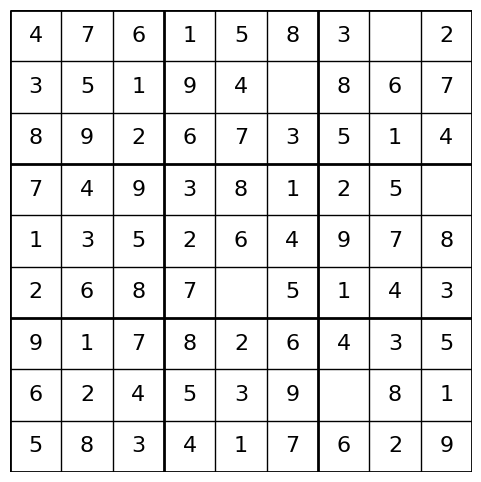

In [17]:
obs, inf = test_env.reset()
test_env.render()

721 True -1


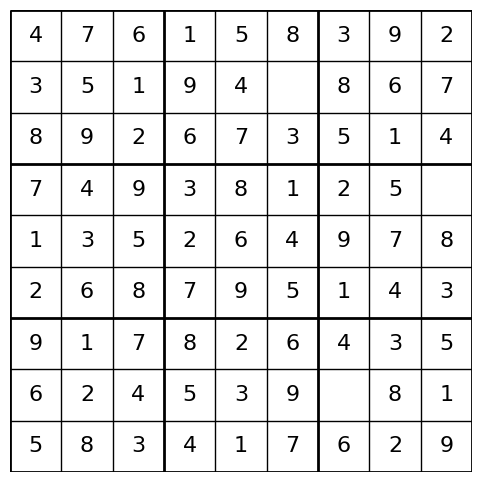

In [20]:
qs = pi(tf.expand_dims(preprocessing(obs), 0))
act = np.argmax(qs)
obs, reward, terminated, _, _ = test_env.step(act)
print(act, terminated, reward)
test_env.render()